<a href="https://colab.research.google.com/github/DietzscheNostoevsky/Learning_Pytorch/blob/main/02_Pytorch_NN_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification using Neural Networks in PyTorch

# 1. Data Generation

## Generation

In [1]:
from sklearn.datasets import make_circles 

# Making 1000 samples 
n_samples = 1000

# creating circles 

X, y = make_circles(n_samples, 
                    noise=0.03, # addded noise 
                    random_state=42) # for replication 
                
print(F"X_values (Features) : \n{X[:5]}\n")
print(F"y_values (labels) : \n{y[:5]}")

X_values (Features) : 
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

y_values (labels) : 
[1 1 1 1 0]


## EDA

In [2]:
# converting to a dataframe
import pandas as pd

circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                        "label":y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [3]:
# counting classes 

circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

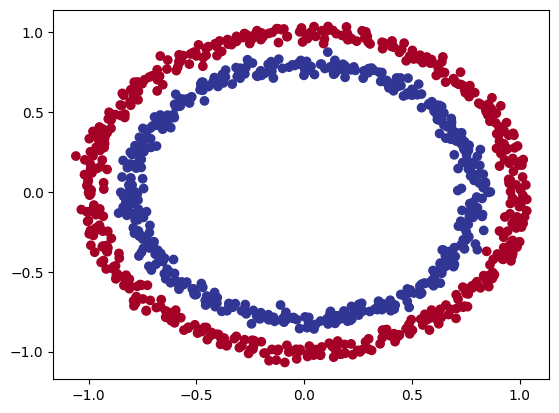

In [4]:
# plotting 

import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],
            y=X[:,1],
                c=y,
                cmap=plt.cm.RdYlBu);


## Input and Output data

In [5]:
# Shape of dataset 
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
# Shape and values of single samples 

X_sample = X[0]
y_sample = y[0]

print(F"Values for one sample of X: {X_sample} and for y: {y_sample}")
print(F"Shapes for one sample of X: {X_sample.shape} and for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and for y: 1
Shapes for one sample of X: (2,) and for y: ()


## Turning data into Tensors 

In [7]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

print(X.type())
print(y.type())

print(X[:5])
print(y[:5])

torch.FloatTensor
torch.FloatTensor
tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]])
tensor([1., 1., 1., 1., 0.])


## Test-Train split 

In [8]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

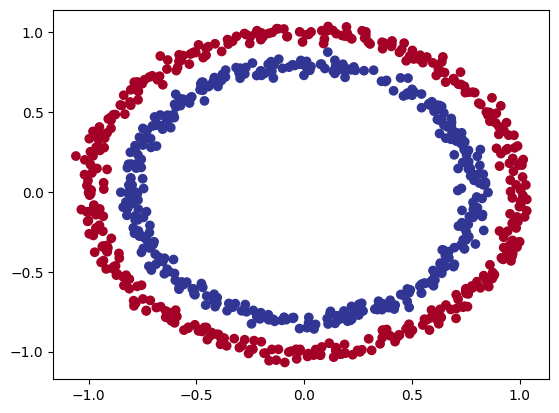

In [9]:
# Plotting train data 
plt.scatter(x=X_train[:,0],
            y=X_train[:,1],
                c=y_train,
                cmap=plt.cm.RdYlBu);

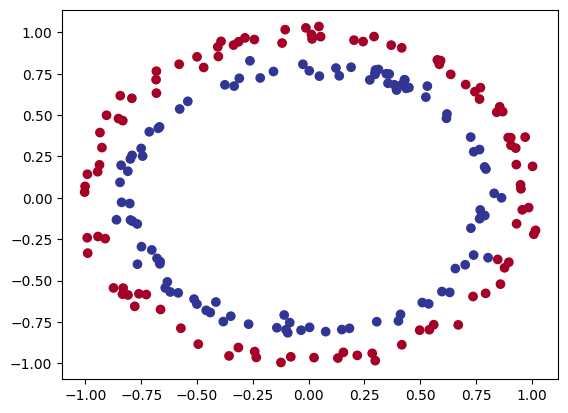

In [10]:
# Plotting test data 
plt.scatter(x=X_test[:,0],
            y=X_test[:,1],
                c=y_test,
                cmap=plt.cm.RdYlBu);

# 2. Building a Model


We'll break it down into a few parts.

-  Setting up device agnostic code (so our model can run on CPU or GPU if it's available).
-  Constructing a model by subclassing nn.Module.
-  Defining a loss function and optimizer.
-  Creating a training loop 



In [11]:
# importing libraries 

import torch
from torch import nn

# Making device agnostic code 

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Creating a model class that:

- Subclasses nn.Module (almost all PyTorch models are subclasses of nn.Module).

- Creates 2 nn.Linear layers in the constructor capable of handling the input and output shapes of X and y.

- Defines a forward() method containing the forward pass computation of the model.

- Instantiates the model class and sends it to the target device.

In [12]:
class CircleModuleV0(nn.Module):
    def __init__(self):
        super().__init__()

        # creating NN layers for inputs 
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    # forward method 
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

# Instantiating the Model 
model_0 = CircleModuleV0().to(device)
model_0


CircleModuleV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

`nn.Sequential` is fantastic for straight-forward computations, however, as the namespace says, **it always runs in sequential order**.

So if you'd something else to happen (rather than just straight-forward sequential computation) you'll want to define your own custom nn.Module subclass.



In [13]:
## Model using nn.Sequential

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
# Making predictions throught the model

untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.0575],
        [-0.1455],
        [ 0.1731],
        [-0.1229],
        [ 0.1731],
        [ 0.1193],
        [-0.1284],
        [-0.0664],
        [ 0.1728],
        [-0.1514]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


Have to change the predictions output to match test labels form and shape

## Setting up loss function and Optimizer

In [15]:
# Creating a loss function 
loss_fn = nn.BCEWithLogitsLoss() # with sigmoid built-in 

# Creating an Optimizer 
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

Creating an evaluation metric.

- An evaluation metric can be used to offer another perspective on how your model is going.

- If a loss function measures how wrong your model is, evaluation metrics as measuring how right it is.

- It can be argued both of these are doing the same thing but evaluation metrics offer a different perspective.

In [16]:
# Creating an accuracy eval metric 

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc
    

# 3. Training the Model

## Raw model to predicted labels 

-  **Logits**

In [17]:
# Checking forward pass output 

y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0575],
        [-0.1455],
        [ 0.1731],
        [-0.1229],
        [ 0.1731]], grad_fn=<SliceBackward0>)

In [18]:
# passing Logits through Sigmoid to get probabilities 

y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4856],
        [0.4637],
        [0.5432],
        [0.4693],
        [0.5432]], grad_fn=<SigmoidBackward0>)

In [19]:
# Turning probabilities into predictions 
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Checking for equality 
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 1., 0., 1.], grad_fn=<SqueezeBackward0>)

In [20]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

Now output format and labels format match

## Building training and testing loop 

In [21]:
# 100 epochs and print progress every 10 
torch.manual_seed(42)

epochs = 100 

# Putting data into device 

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Building training and evaluation loop 

for epoch in range(epochs):

    # Training 

    model_0.train()

    # 1. Forward Pass ( model output -> raw logits)
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculating loss and accuracy 
    loss = loss_fn(y_logits, y_train) # sigmoid not required as already included in loss funtion 
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad 
    optimizer.zero_grad()

    # 4. Backprop 
    loss.backward()

    # 5. Optimizer step 
    optimizer.step()

    # Testing 
    model_0.eval() # EVALUATION MODE 

    with torch.inference_mode():

        # 1. forward pass 
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculating loss/ accuracy 

        test_loss = loss_fn(test_logits, y_test)

        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.69726, Accuracy: 50.25% | Test loss: 0.69075, Test acc: 55.00%
Epoch: 10 | Loss: 0.69658, Accuracy: 49.62% | Test loss: 0.69065, Test acc: 54.50%
Epoch: 20 | Loss: 0.69609, Accuracy: 49.25% | Test loss: 0.69065, Test acc: 54.00%
Epoch: 30 | Loss: 0.69571, Accuracy: 49.50% | Test loss: 0.69070, Test acc: 53.50%
Epoch: 40 | Loss: 0.69540, Accuracy: 49.50% | Test loss: 0.69077, Test acc: 54.00%
Epoch: 50 | Loss: 0.69515, Accuracy: 49.25% | Test loss: 0.69085, Test acc: 54.50%
Epoch: 60 | Loss: 0.69494, Accuracy: 49.00% | Test loss: 0.69094, Test acc: 54.00%
Epoch: 70 | Loss: 0.69476, Accuracy: 49.25% | Test loss: 0.69104, Test acc: 54.50%
Epoch: 80 | Loss: 0.69460, Accuracy: 49.00% | Test loss: 0.69113, Test acc: 53.50%
Epoch: 90 | Loss: 0.69446, Accuracy: 49.38% | Test loss: 0.69123, Test acc: 53.50%


Model is performing just as good as a random guessing right now. (Balanced dataset of 50% ) 

# 4. MAking predictions and evaluating model 

## Vizualizing model output

In [22]:
# Importing helper functions 
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

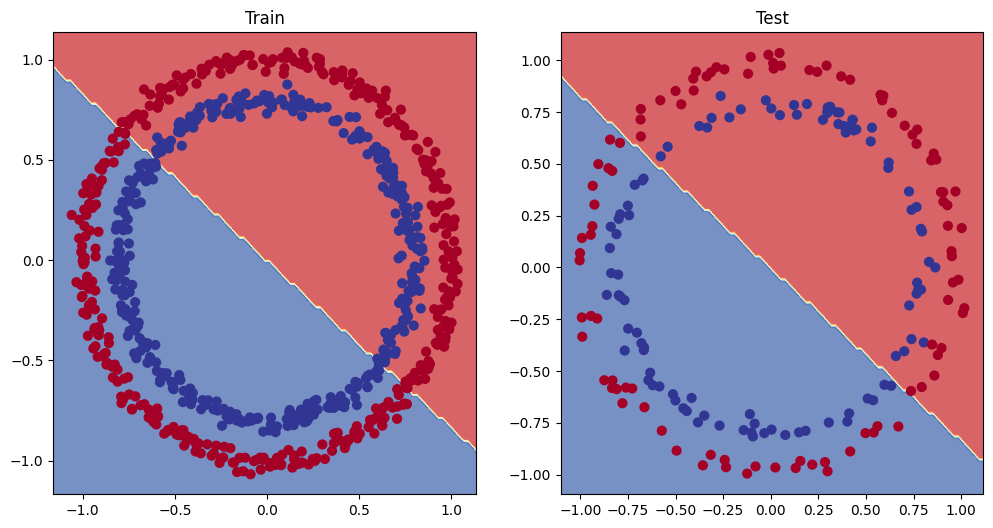

In [23]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)


**Model is *Underfitting***

Need to increase the complexity 

Increasing epochs and Model depth and making it wider 

In [24]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Loss and optimizer 

# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [25]:
# Training Loop  

torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train()
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predicition probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 200 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 300 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 400 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 500 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 600 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 700 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 800 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 900 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%


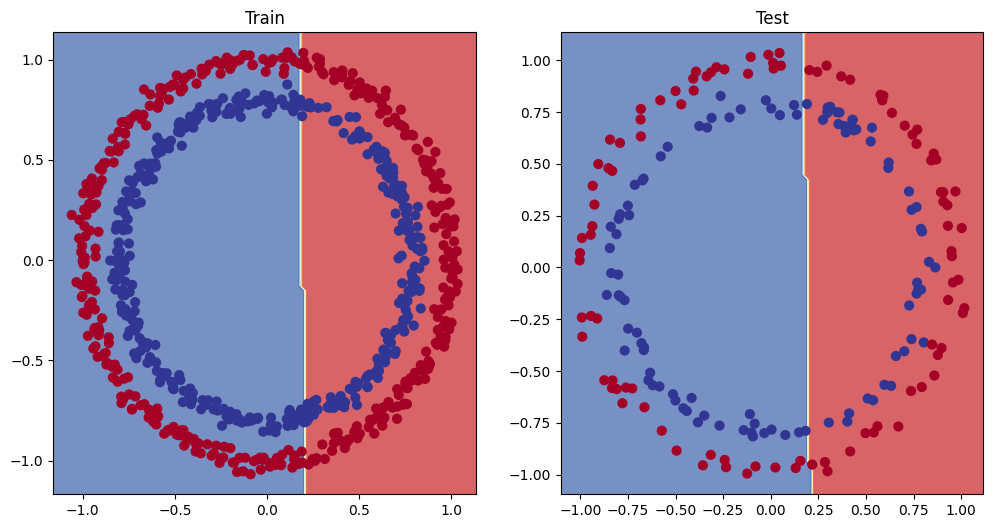

In [26]:
# Vizualize the results 
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## Preparing data to see if our model can model a straight line

100
80 80 20 20


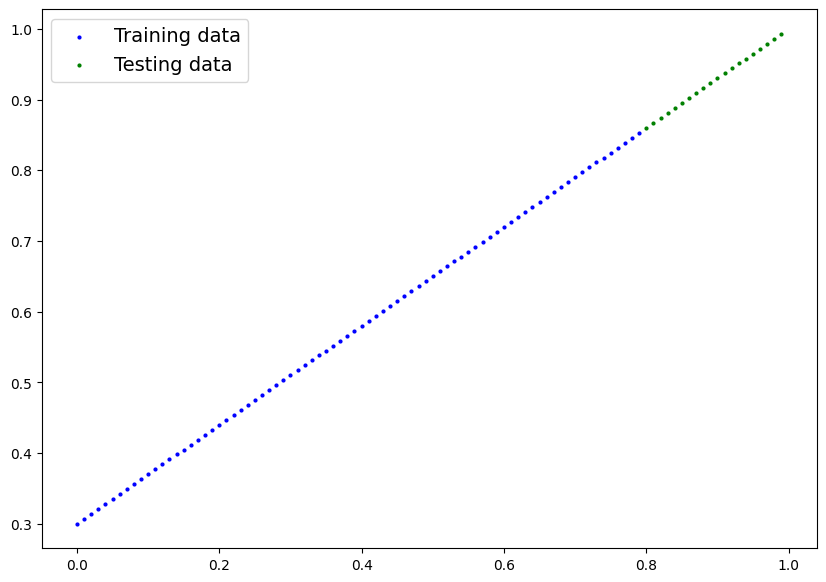

In [27]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]


# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression), 
    len(y_train_regression), 
    len(X_test_regression), 
    len(y_test_regression))


plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);